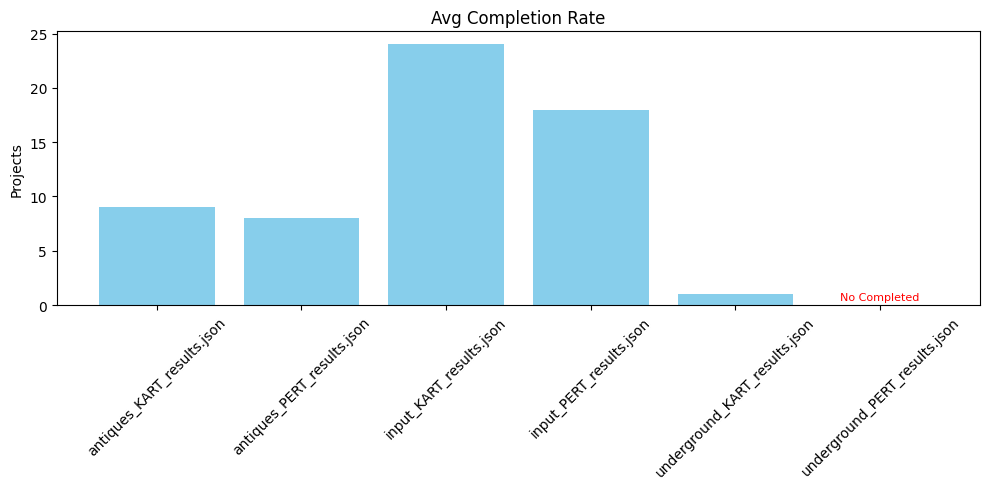

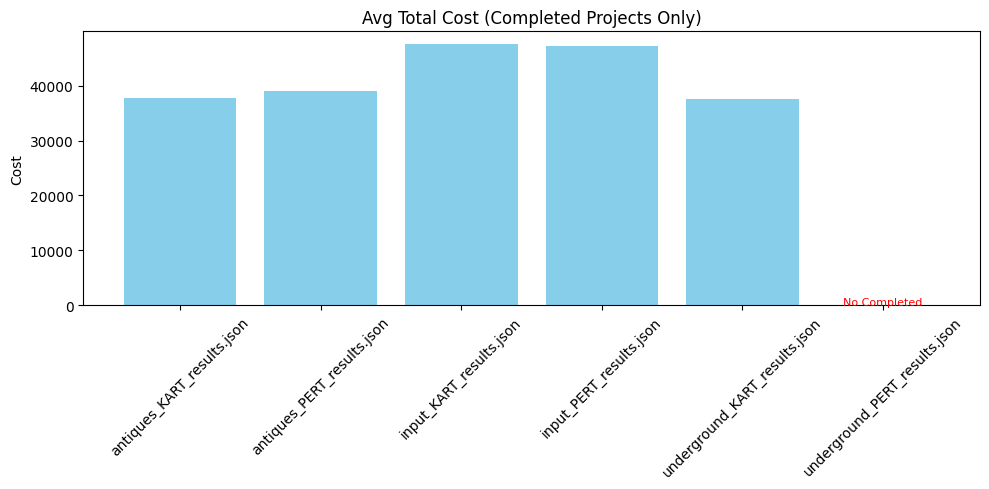

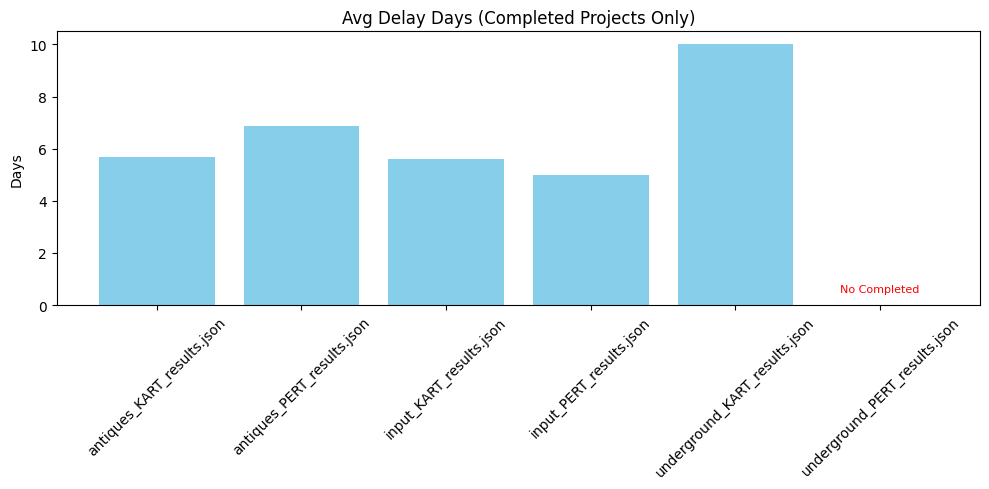

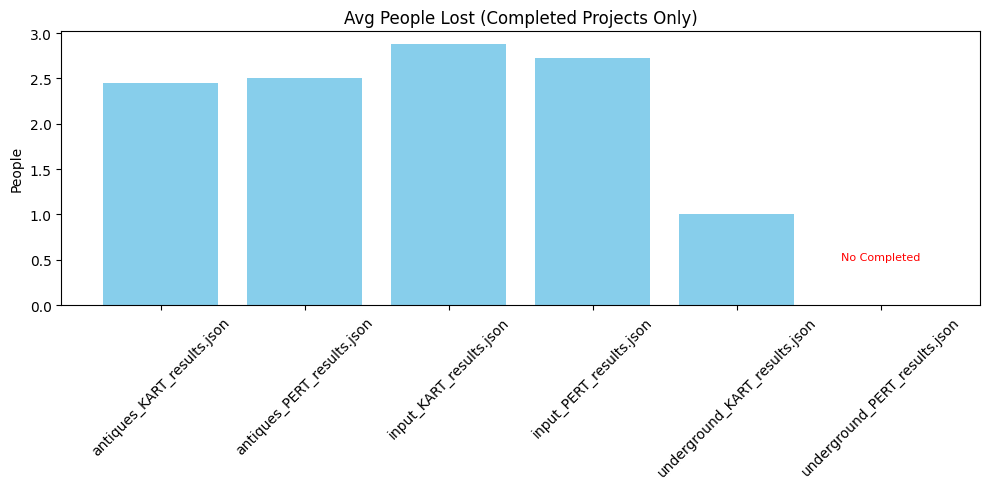

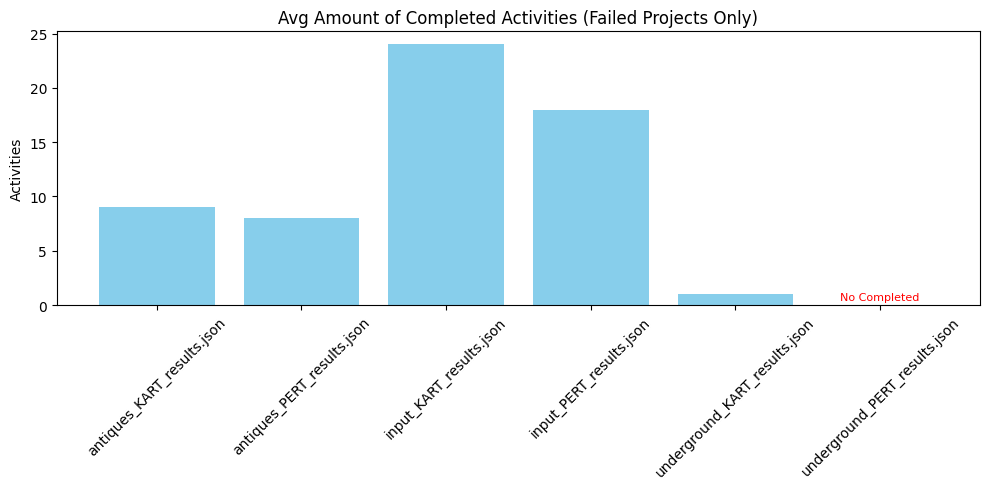

In [20]:
import os
import json
import matplotlib.pyplot as plt

# Ensure plots show inline
%matplotlib inline

FOLDER_PATH = "../data/results"  # Replace with your folder path

stats = {}

for file_name in os.listdir(FOLDER_PATH):
    if not file_name.endswith(".json"):
        continue

    with open(os.path.join(FOLDER_PATH, file_name), "r") as f:
        data = json.load(f)

    file_stats = {
        "completion_rate": int,
        "on_fail_amount_of_finished_activities": [],
        "total_cost": [],
        "delay_days": [],
        "people_lost": []
    }
    file_stats["completion_rate"] = 0

    for run in data:
        if not run.get("projectFinished", False):
            finished = len(run.get("finishedActivities", []))
            file_stats["on_fail_amount_of_finished_activities"].append(finished)
        else:
            total_cost = run.get("totalCost", 0)
            delay = run.get("totalDelayDays", 0)
            people_lost = len(run.get("peopleLost", []))
            
            file_stats["completion_rate"] += 1
            file_stats["total_cost"].append(total_cost)
            file_stats["delay_days"].append(delay)
            file_stats["people_lost"].append(people_lost)

    # Even if empty, include it with zeroes or NaN for display
    if file_stats["completion_rate"]:
        stats[file_name] = {
            "completion_rate": file_stats["completion_rate"],
            "on_fail_amount_of_finished_activities": sum(file_stats["on_fail_amount_of_finished_activities"]) / len(file_stats["on_fail_amount_of_finished_activities"]),
            "total_cost": sum(file_stats["total_cost"]) / len(file_stats["total_cost"]),
            "delay_days": sum(file_stats["delay_days"]) / len(file_stats["delay_days"]),
            "people_lost": sum(file_stats["people_lost"]) / len(file_stats["people_lost"]),
        }
    else:
        stats[file_name] = {
            "completion_rate": 0,
            "total_cost": 0,
            "delay_days": 0,
            "people_lost": 0,
            "incomplete_only": True  # flag it for special display
        }

# Prepare data
labels = list(stats.keys())
completion = [v["completion_rate"] for v in stats.values()]
costs = [v["total_cost"] for v in stats.values()]
delays = [v["delay_days"] for v in stats.values()]
lost = [v["people_lost"] for v in stats.values()]
incomplete_flags = [v.get("incomplete_only", False) for v in stats.values()]

def plot_bar(values, title, ylabel):
    plt.figure(figsize=(10, 5))
    colors = ['lightcoral' if inc else 'skyblue' for inc in incomplete_flags]
    plt.bar(labels, values, color=colors)
    for i, v in enumerate(values):
        if incomplete_flags[i]:
            plt.text(i, v + 0.5, "No Completed", ha='center', color='red', fontsize=8)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bar(completion, "Avg Completion Rate", "Projects")
plot_bar(costs, "Avg Total Cost (Completed Projects Only)", "Cost")
plot_bar(delays, "Avg Delay Days (Completed Projects Only)", "Days")
plot_bar(lost, "Avg People Lost (Completed Projects Only)", "People")
plot_bar(completion, "Avg Amount of Completed Activities (Failed Projects Only)", "Activities")